In [1]:
"""Imports."""

import os
import time
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
from jaxtyping import Float, Int
from PIL import Image
from torch import Tensor, bfloat16, nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import models, transforms
from torchvision.models import DenseNet201_Weights, ResNet34_Weights
from tqdm import tqdm

In [2]:
"""Check Torch version and device"""

print(f"{torch.__version__=}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

torch.__version__='2.5.1+cu121'
device=device(type='cuda')
NVIDIA GeForce RTX 3090


## Set up CNN-LSTM and ensure training works on dummy data

*Note*: Within the model class and the training function, everything is moved to the correct
device. We assume we are working with bfloat16 precision - all model input data is set to bfloat16.

In [3]:
"""Set up CNN-LSTM."""

class CNNLSTM(nn.Module):
    """CNN-LSTM for video event classification."""
    def __init__(
            self,
            cnn_model: nn.Module,  # pre-trained CNN model
            lstm_input_sz: int,  # size of input features expected by LSTM
            lstm_hidden_sz: int,  # number of neurons in each lstm hidden layer
            lstm_n_layers: int,  # number of lstm layers
            n_classes: int,  # number of output classes
            dropout: float = 0.15,  # dropout rate
        ):
        super().__init__()
        n_ch, w, h = 3, 224, 224  # input frame size
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # <s CNN
        self.cnn = cnn_model  # pre-trained CNN model
        self.cnn = self.cnn.to(device, dtype=bfloat16)  # convert to bfloat16 and move to device
        self.cnn.classifier = nn.Identity()  # remove classification head, keep feature extractor
        # Dynamically compute CNN output size
        with torch.no_grad():
            # Simulate a single frame input
            dummy_input = torch.zeros(1, n_ch, w, h, dtype=bfloat16, device=device)
            cnn_output = self.cnn(dummy_input)
            self.cnn_output_size = cnn_output.shape[-1]
        self.cnn2lstm = nn.Linear(  # match CNN out to LSTM in
            self.cnn_output_size,
            lstm_input_sz,
            device=device,
            dtype=bfloat16
        )
        self.cnn_dropout = nn.Dropout(dropout)
        # /s>

        # <s LSTM
        self.lstm = nn.LSTM(
            input_size=lstm_input_sz,
            hidden_size=lstm_hidden_sz,
            num_layers=lstm_n_layers,
            batch_first=True,
            dropout=dropout,
            dtype=bfloat16,
            device=device
        )
        self.lstm_dropout = nn.Dropout(dropout)
        # /s>

        # Fully connected layer for classification
        self.fc = nn.Linear(lstm_hidden_sz, n_classes, device=device, dtype=bfloat16)

    def forward(
        self,
        x: Float[Tensor, "batch_sz seq_len n_channels height width"],  # sequence of frames
    ) -> Float[Tensor, "batch_sz num_classes"]:
        """Forward pass through CNN-LSTM: predicts output classes from frames.

        Args:
            x: The sequences of frames.

        Returns:
            Output tensor containing class probabilities for each sequence.

        Note:
            - The CNN processes each frame independently to extract spatial features.
            - The LSTM processes the sequence of CNN features to capture temporal patterns.
            - Only the final time step output from the LSTM is used for classification.
        """
        seq_len = x.size()[1]

        # Reshape for CNN; extract cnn features for each frame
        cnn_features = []
        for t in range(seq_len):
            frame_features = self.cnn(x[:, t, :, :, :])
            frame_features = self.cnn_dropout(frame_features)
            reduced_features = self.cnn2lstm(frame_features)  # cnn2lstm dimensionality matching
            cnn_features.append(reduced_features)
        cnn_features = torch.stack(cnn_features, dim=1)  # -> (batch_sz, seq_len, feature_sz)

        # Pass through LSTM
        lstm_out, _ = self.lstm(cnn_features)  # -> (batch_sz, seq_len, lstm_hidden_sz)
        lstm_out = self.lstm_dropout(lstm_out)

        # Get the last time step's output for classification
        output = self.fc(lstm_out[:, -1, :])  # -> (batch_sz, num_classes)

        return output

    def weights_init(self):
        """Initialize the weights of the CNN and LSTM layers using Xavier init."""
        for _, module in self.named_modules():
            if isinstance(module, nn.Linear | nn.Conv2d):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.LSTM):
                for param_name, param in module.named_parameters():
                    if 'weight_ih' in param_name or 'weight_hh' in param_name:
                       nn. init.xavier_uniform_(param.data)
                    elif 'bias' in param_name:
                        nn.init.zeros_(param.data)

In [4]:
"""Define some key variables."""

frame_shape = (3, 224, 224)  # (n_channels, height, width)
n_classes = 4
batch_sz = 4
seq_len = 10  # Number of frames (half a second at 30 FPS)
n_channels, height, width = frame_shape[0], frame_shape[1], frame_shape[2]

In [5]:
"""Forward pass on CNN-LSTM on a dummy frame (to make sure things work)."""

# Instantiate model
cnn = models.densenet201(weights=DenseNet201_Weights.DEFAULT)
# cnn = models.resnet34(weights=ResNet201_Weights.DEFAULT)
model = CNNLSTM(cnn, lstm_input_sz=512, lstm_hidden_sz=512, lstm_n_layers=2, n_classes=n_classes)

# Create dummy input (one batch)
dummy_input = torch.randn(batch_sz, seq_len, n_channels, height, width).to(device, dtype=bfloat16)

# Forward pass
output = model(dummy_input)
assert output.shape == (batch_sz, n_classes)  # Expected output: (batch_sz, n_classes)
print(output.shape)

torch.Size([4, 4])


In [6]:
print(model)

CNNLSTM(
  (cnn): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [5]:
"""Define training function."""

def train(
    model: nn.Module,  # model to train
    train_loader: DataLoader,  # training data loader
    val_loader: DataLoader,  # validation data loader
    optimizer: optim.Optimizer,  # optimization algorithm
    max_epochs: int = 2,  # maximum number of epochs to train for
    max_batches: int = 100_000,  # maximum number of batches to train for
    val_every: int = 100,  # validate every n batch
    val_iter: int = 5,  # number of batches on val_loader to run and avg for val loss
    patience_thresh: int = 500,  # consecutive batches w/ no val loss decrease for early stop
) -> tuple[torch.Tensor, list, list, list]:  # -> final loss, train losses, val losses, batch_times
    """Trains the model, returns loss."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bce_loss = nn.BCEWithLogitsLoss()  # binary cross entropy loss w/ sigmoided vals for stability

    # <s Nested helper functions to make `train` more readable.
    def print_losses(epoch, batch_i, train_losses_avg, val_losses_avg):
        """Print current average losses."""
        print(
            f"Epoch {epoch + 1}: Batch {batch_i + 1}:  "
            f"Loss = {train_losses_avg[-1]:.3f}, Val Loss = {val_losses_avg[-1]:.3f}"
        )

    @torch.no_grad()
    def estimate_losses(
        model: nn.Module,
        val_loader: DataLoader,
        val_losses: list[float],
        val_losses_avg: list[float],
        train_losses: list[float],
        train_losses_avg: list[float],
    ):
        """Estimate losses on val_loader, and return val loss and train loss avg."""
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.eval()
        for val_i, (x_val, y_val) in enumerate(val_loader):
            logits = model(x_val.to(device))
            val_loss = bce_loss(logits, y_val.to(device))
            val_losses.append(val_loss.item())
            if val_i >= (val_iter - 1):
                break
        val_losses_avg.append(np.mean(val_losses[-val_iter:]))  # type: ignore
        train_losses_avg.append(np.mean(train_losses[-val_every:]))  # type: ignore
        model.train()
    # /s>

    # <s Trackers
    _batch_sz, n_batches = train_loader.batch_size, len(train_loader)
    batch_lim = min(max_batches, n_batches * max_epochs)
    train_losses, val_losses, train_losses_avg, val_losses_avg, batch_times = [], [], [], [], []
    best_val_loss = float("inf")
    patience_ct = 0
    # /s>

    # <s Training loop
    for epoch in range(max_epochs):
        pbar = tqdm(enumerate(train_loader), total=batch_lim, desc="Batch progression")
        for batch_i, (x_train, y_train) in pbar:
            start_time = time.time()
            # <ss Model training.
            optimizer.zero_grad()
            # Forward pass
            logits = model(x_train.to(device))  # -> (batch_sz, num_classes)
            loss = bce_loss(logits, y_train.to(device))  # targets are float for bce loss
            # Backward pass and params update step
            loss.backward()
            apply_gradient_centralization(optimizer)
            optimizer.step()
            train_losses.append(loss.item())
            batch_times.append(time.time() - start_time)
            # /ss>
            # <ss Model validation.
            if val_every and batch_i % val_every == 0:
                # Estimate and print losses.
                estimate_losses(
                    model,
                    val_loader,
                    val_losses,
                    val_losses_avg,
                    train_losses,
                    train_losses_avg,
                )
                print_losses(epoch, batch_i, train_losses_avg, val_losses_avg)
                pbar.set_postfix_str(f"Total Batch {(batch_i + 1) * (epoch + 1)} / {batch_lim}")
                # Patience check for early stopping.
                patience_ct = (
                    0 if val_losses_avg[-1] < best_val_loss else patience_ct + val_every
                )
                best_val_loss = min(best_val_loss, val_losses_avg[-1])
                if patience_ct >= patience_thresh:
                    print("Early stopping.")
                    print_losses(epoch, batch_i, train_losses_avg, val_losses_avg)
                    return loss, train_losses_avg, val_losses_avg, batch_times
            # Max batch check.
            if (batch_i + 1) * (epoch + 1) >= max_batches:
                print("Finished training:")
                print_losses(epoch, batch_i, train_losses_avg, val_losses_avg)
                return loss, train_losses_avg, val_losses_avg, batch_times
            # /ss>
        # /s>

    print("Finished training:")
    print_losses(epoch, batch_i, train_losses_avg, val_losses_avg)  # type: ignore
    return loss, train_losses_avg, val_losses_avg, batch_times  # type: ignore


def apply_gradient_centralization(optimizer):
    """Applies gradient centralization to the optimizer.

    This function should be called before optimizer.step() in the training loop.
    """
    for group in optimizer.param_groups:
        for param in group["params"]:
            if param.grad is not None:
                # Compute the mean of the gradient
                grad_mean = param.grad.data.mean(
                    dim=tuple(range(1, len(param.grad.shape))), keepdim=True
                )
                # Centralize the gradient
                param.grad.data -= grad_mean

In [6]:
"""Full training of CNN-LSTM on a single dummy frame (to make sure things work)."""

# Instantiate model
cnn = models.densenet201(weights=DenseNet201_Weights.DEFAULT)
# cnn = models.resnet34(weights=ResNet201_Weights.DEFAULT)
model = CNNLSTM(cnn, lstm_input_sz=512, lstm_hidden_sz=512, lstm_n_layers=2, n_classes=n_classes)
model.weights_init()

# Create dummy input and output (one batch)
dummy_in = torch.randint(
    0, 256, size=(batch_sz * 2, seq_len, n_channels, height, width), dtype=bfloat16
) / 255.
dummy_out = torch.randint(0, 2, size=(batch_sz * 2, n_classes)).float()

# Create data loaders
dataset = TensorDataset(dummy_in, dummy_out)
train_sz, val_sz = 1, 1
train_dataset, val_dataset = random_split(dataset, [batch_sz, batch_sz])
train_loader = DataLoader(
    train_dataset, batch_size=batch_sz, shuffle=True, num_workers=4
)
val_loader = DataLoader(val_dataset, batch_size=batch_sz, shuffle=True, num_workers=4)

# Train
loss, train_losses, val_losses, batch_times = train(
    model,
    train_loader,
    val_loader,
    optim.Adam(model.parameters(), lr=1e-3, fused=True),
    max_batches=1,
)
print(train_losses, val_losses)

Batch progression:   0%|          | 0/1 [00:06<?, ?it/s, Total Batch 1 / 1]


Epoch 1: Batch 1:  Loss = 0.695, Val Loss = 0.547
Finished training:
Epoch 1: Batch 1:  Loss = 0.695, Val Loss = 0.547
[0.6950092315673828] [0.5467529296875]


## Full training of CNN-LSTM on real images and labels

In [7]:
"""Define paths and some key variables."""

labels_path = "data/LSTMLabels.csv"
vid_path = "data/cut_clip_downsampled_liv_mnc.mp4"
write_path = "data/frames"
frame_col = "Frame Number"

labels_df = pd.read_csv(labels_path)
frames = labels_df[frame_col].values
vidcap = cv2.VideoCapture(vid_path)
os.makedirs(write_path, exist_ok=True)

In [ ]:
"""Extract frames from video."""

for f in frames:
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, f)
    read_success, image = vidcap.read()
    if read_success:
        write_success = cv2.imwrite(f"{write_path}/frame_{f}.png", image)
        if not write_success:
            print(f"Failed to write frame {f}")
    else:
        print(f"Failed to read frame {f}")
vidcap.release()

In [8]:
"""Initialize target outputs: read labels and convert them to 2-d tensor"""

label_cols = ["Possession", "Passing", "InPlay", "Goals"]
Y = labels_df[label_cols].values
Y = torch.from_numpy(Y).float()


In [9]:
"""Initialize inputs: convert frames to 5-d tensor (frames X seq_len X rgb X height X width)"""

seq_len = 10
n_sequences = len(frames) - seq_len + 1

frames_path = Path(write_path)
# Initialize X_int and X
X_init = torch.empty(len(frames), n_channels, height, width, dtype=torch.bfloat16)
X = torch.empty(n_sequences, seq_len, n_channels, height, width, dtype=torch.bfloat16)

for i, f in enumerate(frames_path.glob("*.png")):
    with Image.open(f).convert("RGB") as img:  # open image file and convert to RGB
        # Create transforms
        to_tensor = transforms.ToTensor()
        resize = transforms.Resize((height, width))
        # Apply transforms
        img_tensor = to_tensor(img).float()
        img_tensor = resize(img_tensor)
        X_init[i, :] = img_tensor

for s in range(n_sequences):
    X[s] = X_init[s : (s + seq_len)]

# Ensure Y and X have the same number of sequences
Y = Y[:n_sequences]

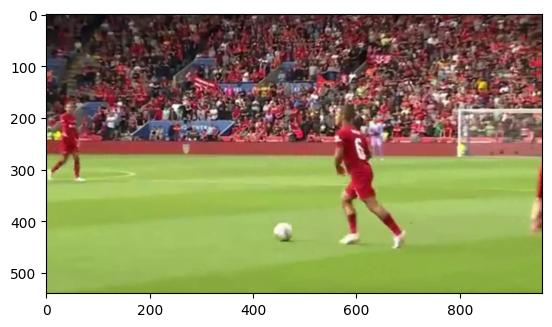

In [10]:
"""See example image."""

plt.imshow(img)

In [11]:
"""Create datasets and train."""

batch_sz, n_workers = 4, 4

# Create data loaders
dataset = TensorDataset(X, Y)
train_ratio, val_ratio, test_ratio = 0.85, 0.1, 0.05
train_data, val_data, test_data = random_split(dataset, [train_ratio, val_ratio, test_ratio])

train_loader = DataLoader(train_data, batch_size=batch_sz, shuffle=True, num_workers=n_workers)
val_loader = DataLoader(val_data, batch_size=batch_sz, shuffle=True, num_workers=n_workers)
test_loader = DataLoader(test_data, batch_size=batch_sz, shuffle=False, num_workers=n_workers)

# Train
model = CNNLSTM(
    cnn,
    lstm_input_sz=512,
    lstm_hidden_sz=512,
    lstm_n_layers=2,
    n_classes=n_classes
)
model.weights_init()
loss, train_losses, val_losses, batch_times = train(
    model,
    train_loader,
    val_loader,
    optim.Adam(model.parameters(), lr=1e-3, fused=True),
    max_batches=250,
    val_every=25,
)

Batch progression:   0%|          | 1/250 [00:06<26:58,  6.50s/it, Total Batch 1 / 250]

Epoch 1: Batch 1:  Loss = 0.685, Val Loss = 0.559


Batch progression:  10%|█         | 26/250 [00:30<07:14,  1.94s/it, Total Batch 26 / 250]

Epoch 1: Batch 26:  Loss = 0.386, Val Loss = 0.539


Batch progression:  20%|██        | 51/250 [00:54<06:23,  1.93s/it, Total Batch 51 / 250]

Epoch 1: Batch 51:  Loss = 0.405, Val Loss = 0.363


Batch progression:  30%|███       | 76/250 [01:17<05:37,  1.94s/it, Total Batch 76 / 250]

Epoch 1: Batch 76:  Loss = 0.431, Val Loss = 0.406


Batch progression:  40%|████      | 101/250 [01:41<04:45,  1.92s/it, Total Batch 101 / 250]

Epoch 1: Batch 101:  Loss = 0.409, Val Loss = 0.473


Batch progression:  50%|█████     | 126/250 [02:05<03:59,  1.93s/it, Total Batch 126 / 250]

Epoch 1: Batch 126:  Loss = 0.409, Val Loss = 0.430


Batch progression:  60%|██████    | 151/250 [02:29<03:11,  1.93s/it, Total Batch 151 / 250]

Epoch 1: Batch 151:  Loss = 0.427, Val Loss = 0.430


Batch progression:  70%|███████   | 176/250 [02:53<02:23,  1.94s/it, Total Batch 176 / 250]

Epoch 1: Batch 176:  Loss = 0.375, Val Loss = 0.385


Batch progression:  80%|████████  | 201/250 [03:16<01:34,  1.93s/it, Total Batch 201 / 250]

Epoch 1: Batch 201:  Loss = 0.478, Val Loss = 0.475


Batch progression:  90%|█████████ | 226/250 [03:40<00:46,  1.93s/it, Total Batch 226 / 250]

Epoch 1: Batch 226:  Loss = 0.444, Val Loss = 0.395


Batch progression: 100%|█████████▉| 249/250 [03:59<00:00,  1.04it/s, Total Batch 226 / 250]

Finished training:
Epoch 1: Batch 250:  Loss = 0.444, Val Loss = 0.395


## Hyperparameter tuning

In [ ]:
"""Hyperparameters to play with"""

#   - seq_length
#   - dropout
#   - optimizer type (Adam or AdamW, both with `fused=true`)
#   - learning rate
#   - betas
#   - weight decay

# Also you can swap resnet34 for densenet201, and decrease/increase the number of hidden units 
# in the LSTM, and see how this affects training time.

In [ ]:
"""Hyperparameter tuning with Optuna: define Optuna objective function"""

# Set some constants.
labels_path = Path("data/LSTMLabels.csv")
frames_path = Path("data/frames")
frame_shape = (3, 224, 224)  # (n_channels, height, width)
n_channels, height, width = frame_shape[0], frame_shape[1], frame_shape[2]
n_classes = 4
batch_sz = 4  # 8, 16

# Set pre-trained cnn.
cnn = models.densenet201(weights=DenseNet201_Weights.DEFAULT)


def objective(trial):
    """Optuna objective function."""
    # 1. Sample Hyperparameters
    seq_len = trial.suggest_categorical("seq_len", [10, 15])  # 15, 20, 25, 30
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW"])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    beta1 = trial.suggest_float("beta1", 0.9, 0.99)
    beta2 = trial.suggest_float("beta2", 0.9, 0.999)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # 2. Define Model
    lstm_input_sz = 512  # Fixed; adjust if necessary
    lstm_hidden_sz = 512  # Fixed; adjust if necessary
    model = CNNLSTM(
        cnn_model=cnn,
        lstm_input_sz=lstm_input_sz,
        lstm_hidden_sz=lstm_hidden_sz,
        lstm_n_layers=2,
        n_classes=n_classes,
        dropout=dropout,
    )
    model.weights_init()

    # 3. Define Optimizer
    if optimizer_name == "Adam":
        optimizer = optim.Adam(
            model.parameters(),
            lr=learning_rate,
            betas=(beta1, beta2),
            weight_decay=weight_decay,
            fused=True,
        )
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            betas=(beta1, beta2),
            weight_decay=weight_decay,
            fused=True,
        )
    else:
        raise ValueError("Unsupported optimizer type.")

    # 4. Prepare Data Loaders with Specified Sequence Length

    # Target outputs
    labels_df = pd.read_csv(labels_path)
    label_cols = ["Possession", "Passing", "InPlay", "Goals"]
    Y = labels_df[label_cols].values
    Y = torch.from_numpy(Y).float()

    # Inputs
    n_sequences = len(labels_df) - seq_len + 1
    X_init = torch.empty(len(frames), n_channels, height, width, dtype=torch.bfloat16)
    X = torch.empty(n_sequences, seq_len, n_channels, height, width, dtype=torch.bfloat16)
    for i, f in enumerate(frames_path.glob("*.png")):
        with Image.open(f).convert("RGB") as img:  # open image file and convert to RGB
            # Create transforms
            to_tensor = transforms.ToTensor()
            resize = transforms.Resize((height, width))
            # Apply transforms
            img_tensor = to_tensor(img).float()
            img_tensor = resize(img_tensor)
            X_init[i, :] = img_tensor
    for s in range(n_sequences):
        X[s] = X_init[s : (s + seq_len)]

    # Ensure Y and X have the same number of sequences
    Y = Y[:n_sequences]

    # 5. Train the Model
    val_loss = train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        max_epochs=1,
    )

    return val_loss

In [ ]:
"""Hyperparameter tuning with Optuna: run the Optuna study"""

# Define a single-objective study to minimize validation loss
study = optuna.create_study(direction="minimize", study_name="CNN-LSTM")

# Optimize the objective function
study.optimize(objective, n_trials=50, timeout=(60 * 60 * 2))  # type: ignore

# Print info on all trials and best trial
print(f"Number of finished trials: {len(study.trials)} \n")
print("Best trial:")
trial = study.best_trial
print(f"  Validation Loss: {trial.value}")
print("  Best hyperparameters: \n\n")
for key, value in trial.params.items():
    print(f"  {key}: {value}")